# CNZS Pilot Test Survey 
This notebook processes and reformats pilot test survey responses based on defined steps

## 📘 Step 0 — Setup & Configuration

In [1]:
# Step 0 — Setup and Configuration
import pandas as pd
import numpy as np
import os
from difflib import get_close_matches
from fuzzywuzzy import fuzz, process  # or use rapidfuzz for faster execution

/Users/jasrajgill/anaconda3/lib/python3.11/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
# Define input and output paths
INPUT_FILE = os.path.expanduser("../input/2025-11-19_PC2 SM data export.xlsx")
OUTPUT_DIR = os.path.expanduser("../output/intermediate_checks")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Helper to save files
def save_df(df, name):
    """Save dataframe to Excel in the output directory."""
    path = os.path.join(OUTPUT_DIR, f"{name}.xlsx")
    df.to_excel(path, index=False)
    print(f"✅ Saved: {path}")


## 🧹 Step 1 — Load and Prepare Data

In [3]:
# Step 1 — Load and Prepare Data
def load_and_prepare_data(file_path):
    df = pd.read_excel(file_path)
    print(f"Loaded {df.shape[0]} rows, {df.shape[1]} columns")

    # Replace 'Not Answered' with NaN
    df.replace('Not Answered', np.nan, inplace=True)

    # Normalize column names
    df.columns = df.columns.str.strip()

    # Clean key identifier columns
    id_cols = ['First name  ', 'Last name  ', 'Email address']
    for col in id_cols:
        if col in df.columns:
            df[col] = (
                df[col].astype(str)
                .str.strip()
                .str.lower()
                .str.replace(r'\s+', '', regex=True)
            )

    # Rename key meta columns for clarity
    df.rename(
        columns={
            "What country is your organization headquartered in? If you are responding in a personal capacity, select the country where you are based.": "Country",
            "If you are a Corporate, Financial Institution, or Professional Service & Consultancy:What sector does your company operate in?": "Sector",
            "If you are a Corporate, Financial Institution, or Professional Service & Consultancy:What is your company’s SBTi status?": "SBTi Status",
            "If you are a Corporate, Financial Institution, or Professional Service & Consultancy:Select the range that best represents your total number of full-time employees in your most recent reporting year.": "Employees MRY",
            "If you are a Corporate, Financial Institution, or Professional Service & Consultancy:What was your company’s net annual turnover in the most recent reporting year(revenue)?": "Annual Turnover MRY",
        },
        inplace=True
    )

    # Keep only completed responses
    if 'Response Status' in df.columns:
        df = df[df['Response Status'].str.lower() == 'completed']
        print(f"✅ Filtered completed responses: {df.shape[0]} rows")

    save_df(df, "full_dataset_with_manual_submissions_CHECK")
    return df

df = load_and_prepare_data(INPUT_FILE)


Loaded 108 rows, 441 columns
✅ Filtered completed responses: 26 rows
✅ Saved: ../output/intermediate_checks/full_dataset_with_manual_submissions_CHECK.xlsx


In [4]:
column_list = df.columns.tolist()
print(column_list)

['Response ID', 'Date Created', 'Date Modified', 'IP Address', 'Duration (sec)', 'Response Status', 'Email', 'First Name', 'Last Name', 'Collector ID', 'Collector Type', 'Custom Value', 'First name', 'Last name', 'Job title', 'Email address', 'Organization name', 'Type of organization', 'SBTi Status', 'Annual Turnover MRY', 'Employees MRY', 'Sector', 'Are you responding to this survey based on your experience and understanding of:', 'Are you a current or previous SBTi advisory or working group member?', 'If so, which group (select as many as are relevant): | Scientific Advisory Group', 'If so, which group (select as many as are relevant): | Technical Advisory Group', 'If so, which group (select as many as are relevant): | Corporate Net-Zero Standard V2.0 Expert Working Groups', 'If so, which group (select as many as are relevant): | BVCM Expert Advisory Group', 'If so, which group (select as many as are relevant): | MRV Expert Advisory Group', 'If so, which group (select as many as are

In [5]:
"Annual Turnover MRY" in df.columns

True

## 🔁 Step 2 — Remove Duplicates (Keep Latest by Date Modified)

In [6]:
# Step 2 — Remove duplicates (keep latest by Date Modified)
def remove_duplicates(df, key_cols=None, date_col="Date Modified"):
    """
    Removes duplicate survey responses based on a set of key columns,
    keeping the most recent response by 'Date Modified'.
    
    Also exports a grouped file for manual duplicate verification.
    """
    if key_cols is None:
        key_cols = ['First name', 'Last name', 'Email address']

    # Defensive: ensure the date column exists
    if date_col not in df.columns:
        raise KeyError(f"Column '{date_col}' not found in dataset.")

    # Sort descending by date (latest first)
    df_sorted = df.sort_values(by=date_col, ascending=False)

    # Remove duplicates (keep latest)
    df_deduped = df_sorted.drop_duplicates(subset=key_cols, keep='first').copy()
    print(f"✅ Removed {len(df_sorted) - len(df_deduped)} duplicates (kept latest by '{date_col}')")

    # Identify all duplicate groups (including the kept entry)
    duplicate_mask = df_sorted.duplicated(subset=key_cols, keep=False)
    duplicates = df_sorted[duplicate_mask].copy()

    if not duplicates.empty:
        # Sort by key cols ascending and date descending
        sort_cols = key_cols + [date_col]
        ascending_flags = [True] * len(key_cols) + [False]
        duplicates = duplicates.sort_values(by=sort_cols, ascending=ascending_flags)

        # Add a group label for manual inspection
        duplicates['Duplicate Group'] = duplicates.groupby(key_cols, dropna=False).ngroup() + 1

        # Reorder to make 'Duplicate Group' visible first
        cols = ['Duplicate Group'] + [col for col in duplicates.columns if col != 'Duplicate Group']
        duplicates = duplicates[cols]

        # Export duplicates to Excel
        save_df(duplicates, "row_wise_duplicates_for_verification")

        print(f"⚠️ {duplicates['Duplicate Group'].nunique()} duplicate groups exported for manual verification.")
    else:
        print("✅ No duplicate groups found.")

    # Return the cleaned dataframe
    return df_deduped.reset_index(drop=True)

# Run the deduplication process
df_final = remove_duplicates(df)
print(f"Final shape after deduplication: {df_final.shape}")


✅ Removed 0 duplicates (kept latest by 'Date Modified')
✅ No duplicate groups found.
Final shape after deduplication: (26, 441)


## After manual inspection, keep those duplicate pairs that are not true duplicates

In [7]:
# Insert code from PC1 notebook one if manual inspection returns non-true duplicates. Else delete this code chunk and above markdown

## 🚩 Step 3 — Flag Suspicious Responses
### Identify suspicious responses with no legitimate name, organization or email (true anonymous) BUT DO NOT REMOVE

In [8]:
# Step 3 — Flag suspicious responses
def flag_suspicious(df):
    suspicious_values = {np.nan, 'a', 'test', 'na', 'n/a', 'none', '.', '-', 'null', 'undefined', 'anon'}
    cols = ['First name', 'Last name', 'Organization name']

    # Identify suspicious rows
    suspicious_mask = (
        df['First name'].isin(suspicious_values)
        | df['Last name'].isin(suspicious_values)
        | df['Organization name'].isin(suspicious_values)
        | (df['First name'].astype(str).str.len() <= 1)
        | (df['Last name'].astype(str).str.len() <= 1)
        | (df['Organization name'].astype(str).str.len() <= 1)
    )

    df["suspicious_flag"] = suspicious_mask
    suspicious = df[df["suspicious_flag"]]
    print(f"⚠️  Flagged {len(suspicious)} suspicious responses (not removed)")
    save_df(suspicious, "suspicious_responses")

    return df

df = flag_suspicious(df)


⚠️  Flagged 3 suspicious responses (not removed)
✅ Saved: ../output/intermediate_checks/suspicious_responses.xlsx


/var/folders/8s/5kdv3m8j75g0mdgd4xxydrg00000gn/T/ipykernel_39883/2927876062.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["suspicious_flag"] = suspicious_mask


## 🏢 Step 4 — Identify Companies with Multiple Submissions

In [9]:
def normalize_company_names(df, org_col="Organization name", threshold=90):
    """
    Normalize organization names using fuzzy matching and identify duplicates.
    """
    from fuzzywuzzy import process
    import os
    import pandas as pd

    print("🔍 Normalizing organization names...")

    # Clean and standardize company names
    df["org_normalized"] = df[org_col].astype(str).str.strip().str.lower()

    # Deduplicate via fuzzy logic
    unique_names = df["org_normalized"].dropna().unique().tolist()
    name_map = {}

    for name in unique_names:
        if name not in name_map:
            match, score = process.extractOne(name, unique_names)
            if score >= threshold:
                name_map[name] = match

    df["org_normalized"] = df["org_normalized"].map(name_map).fillna(df["org_normalized"])
    print(f"✅ Normalized {len(name_map)} organization name variants.")

    # Count and identify companies with multiple responses
    response_counts = df["org_normalized"].value_counts().reset_index()

    # 👇 Handle Pandas version differences safely
    if "index" in response_counts.columns:
        response_counts.columns = ["Company", "Response Count"]
    elif "org_normalized" in response_counts.columns:
        response_counts.columns = ["Company", "Response Count"]
    else:
        # fallback naming for unexpected structures
        response_counts.rename(columns={response_counts.columns[0]: "Company",
                                        response_counts.columns[1]: "Response Count"}, inplace=True)

    # 🔧 Ensure numeric
    response_counts["Response Count"] = pd.to_numeric(response_counts["Response Count"], errors="coerce")

    # Filter multiple entries
    multiple_entries = response_counts.loc[response_counts["Response Count"] > 1, "Company"]

    # Save results
    os.makedirs("intermediate_checks", exist_ok=True)
    response_counts.to_excel("intermediate_checks/company_response_counts.xlsx", index=False)

    df_multiple = df[df["org_normalized"].isin(multiple_entries)]

    print(f"📊 Found {len(multiple_entries)} companies with multiple responses.")

    return df, response_counts, df_multiple


In [10]:
df_final, response_counts, df_multiple = normalize_company_names(df_final)

🔍 Normalizing organization names...
✅ Normalized 26 organization name variants.
📊 Found 0 companies with multiple responses.


## 🧩 Step 5 — Categorize Responses as Category A or B

In [11]:
# ---------------------------------------------------------------------
# 🔹 Load and Prepare Reference Lists
# ---------------------------------------------------------------------
def load_country_lists(world_bank_path, income_group_path, sheet_name="List of economies"):
    """Load and clean World Bank and income group country lists."""
    wb_df = pd.read_excel(world_bank_path)
    wb_df.replace('Egypt, Arab Rep.', 'Egypt', inplace=True)
    world_bank_list = wb_df["Economy"].dropna().str.strip().tolist()

    income_df = pd.read_excel(income_group_path, sheet_name=sheet_name)
    income_df.replace('Egypt, Arab Rep.', 'Egypt', inplace=True)
    cat_b_list = income_df[
        income_df["Income group"].isin(["Low income", "Lower middle income"])
    ]["Economy"].dropna().str.strip().tolist()

    # Save comparison for audit
    compare_country_lists(world_bank_list, cat_b_list)

    return world_bank_list, cat_b_list

In [12]:
# ---------------------------------------------------------------------
# 🔹 Compare Lists Side-by-Side
# ---------------------------------------------------------------------
def compare_country_lists(list1, list2):
    """Generate side-by-side comparison Excel output."""
    os.makedirs("intermediate_checks", exist_ok=True)
    set1, set2 = set(list1), set(list2)
    all_items = sorted(set1.union(set2))

    df_compare = pd.DataFrame({
        "Country": all_items,
        "In World Bank": [c in set1 for c in all_items],
        "In CAT_B List": [c in set2 for c in all_items],
    })
    df_compare["Status"] = df_compare.apply(
        lambda r: "Both" if r["In World Bank"] and r["In CAT_B List"]
        else "Only in World Bank" if r["In World Bank"]
        else "Only in CAT_B List",
        axis=1
    )
    df_compare.to_excel("intermediate_checks/country_list_compare.xlsx", index=False)
    print(f"✅ Saved country list comparison — {len(df_compare)} entries")

In [13]:
# ---------------------------------------------------------------------
# 🔹 Category Classification Logic
# ---------------------------------------------------------------------
def classify_category(row, revenue_col, employees_col, country_col, cat_b_countries):
    """Apply logic to classify rows as Category A or B."""
    revenue = str(row[revenue_col]).strip().lower()
    employees = str(row[employees_col]).strip().lower()
    country = str(row[country_col]).strip().lower()

    # Missing values
    if revenue in ["not answered", ""] or employees in ["not answered", ""] \
       or pd.isna(row[revenue_col]) or pd.isna(row[employees_col]):
        return np.nan

    # Category B: small companies
    if "<50m" in revenue and "fewer than 250" in employees:
        return "Category B"

    # Category B: medium companies from eligible (CAT B) countries
    if ("50-450m" in revenue or "between 250" in employees) \
       and country in [c.lower() for c in cat_b_countries]:
        return "Category B"

    return "Category A"

In [14]:
# ---------------------------------------------------------------------
# 🔹 Wrapper Function to Apply Classification
# ---------------------------------------------------------------------
def apply_category_classification(df, world_bank_list, cat_b_list,
                                  revenue_col="Annual Turnover MRY",
                                  employees_col="Employees MRY",
                                  country_col="Country"):
    """Add Category A/B classification and perform mismatch checks."""
    print("🏷️ Classifying Category A/B...")

    df["Category A/B"] = df.apply(
        classify_category, axis=1,
        revenue_col=revenue_col, employees_col=employees_col,
        country_col=country_col, cat_b_countries=cat_b_list
    )

    print(df["Category A/B"].value_counts(dropna=False))

    os.makedirs("intermediate_checks/overall_dist", exist_ok=True)
    df["Category A/B"].value_counts(dropna=False).to_csv(
        "intermediate_checks/overall_dist/catA_B.csv"
    )

    # Optional visualization
    df["Category A/B"].value_counts(dropna=False).plot(kind="bar")

    # Verify countries match WB list
    verify_country_matches(df, world_bank_list, country_col)

    return df

In [15]:
# ---------------------------------------------------------------------
# 🔹 Fuzzy Match Check for Country Mismatches
# ---------------------------------------------------------------------
def verify_country_matches(df, world_bank_list, country_col):
    """Print likely mismatches between survey country names and WB list."""
    print("\n🔍 Checking for potential mismatches in country names...")
    wb_lower = [c.strip().lower() for c in world_bank_list]
    cat_a_countries = (
        df[df["Category A/B"] == "Category A"][country_col]
        .dropna().str.strip().str.lower().unique()
    )

    for c in cat_a_countries:
        match, score = process.extractOne(c, wb_lower)
        if score >= 80 and c != match:
            print(f"- '{c}' ≈ '{match}' (score: {score})")


✅ Saved country list comparison — 77 entries
🏷️ Classifying Category A/B...
Category A/B
Category A    18
Category B     4
NaN            4
Name: count, dtype: int64

🔍 Checking for potential mismatches in country names...


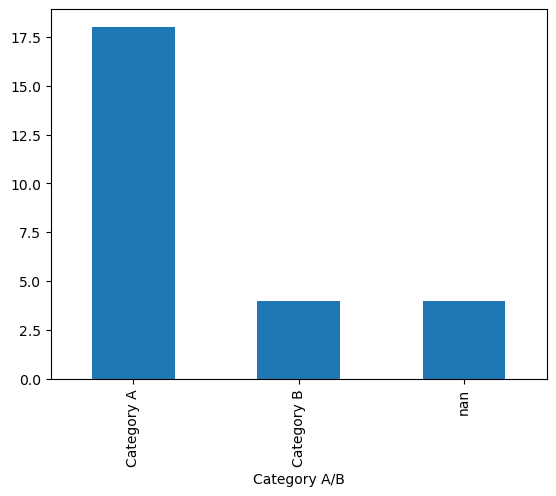

In [16]:
# ---------------------------------------------------------------------
# ✅ Run Step 5
# ---------------------------------------------------------------------
world_bank_list, cat_b_list = load_country_lists(
    "../input/WORLD_BANK_NO_BLANK.xlsx",
    "../input/CLASS (4).xlsx"
)

df_final = apply_category_classification(df_final, world_bank_list, cat_b_list)

## 🌍 Step 6 — Add Region & World Bank Category

In [17]:
# ---------------------------------------------------------------------
# ✅ STEP 6: Integrate World Bank Income Groups and UNGC Regions
# --------------------------------------------------------------------

# ---------------------------------------------------------------------
# A. Load and normalize input data
# ---------------------------------------------------------------------
def load_income_and_region_data(income_path, region_path):
    """Load income group and region data with clean column names."""
    income_df = pd.read_excel(income_path)
    region_df = pd.read_csv(region_path)

    # Normalize naming
    income_df.replace("Taiwan, China", "Taiwan, Province of China", inplace=True)

    # Rename for clarity
    income_df = income_df.rename(columns={
        "Economy": "Country",
        "Income group": "World Bank Income Group"
    })
    region_df = region_df.rename(columns={
        "Location": "Country"
    })

    print(f"✅ Loaded {len(income_df)} income entries and {len(region_df)} region entries.")
    return income_df, region_df

In [18]:
# ---------------------------------------------------------------------
# B. Fuzzy mapping utility
# ---------------------------------------------------------------------
def fuzzy_country_map(source_series, target_choices, threshold=90):
    """Create a dictionary mapping source countries to closest fuzzy match."""
    mapped = {}
    for country in source_series.dropna().unique():
        match, score = process.extractOne(country, target_choices)
        if score >= threshold:
            mapped[country] = match
    return mapped


def apply_country_mappings(df, income_df, region_df, threshold=90):
    """Apply fuzzy country mappings for income and region datasets."""
    income_choices = income_df["Country"].dropna().unique()
    region_choices = region_df["Country"].dropna().unique()

    income_map = fuzzy_country_map(df["Country"], income_choices, threshold)
    region_map = fuzzy_country_map(df["Country"], region_choices, threshold)

    df["Country_income"] = df["Country"].map(income_map)
    df["Country_region"] = df["Country"].map(region_map)
    print(f"✅ Applied fuzzy mapping for {len(income_map)} income and {len(region_map)} region matches.")
    return df

In [19]:
# ---------------------------------------------------------------------
# C. Merge results and validate
# ---------------------------------------------------------------------
def merge_income_and_region(df, income_df, region_df):
    """Merge World Bank Income Group and Region info into main DataFrame."""
    # Merge income
    df = df.merge(
        income_df[["Country", "World Bank Income Group"]],
        left_on="Country_income", right_on="Country", how="left"
    ).drop(columns=["Country_y"], errors="ignore").rename(columns={"Country_x": "Country"})

    # Merge region
    df = df.merge(
        region_df[["Country", "Region"]],
        left_on="Country_region", right_on="Country", how="left"
    ).drop(columns=["Country_y"], errors="ignore").rename(columns={"Country_x": "Country"})

    # Drop helper columns
    df = df.drop(columns=["Country_income", "Country_region"], errors="ignore")

    # Validation summary
    missing_income = df["World Bank Income Group"].isna().sum()
    missing_region = df["Region"].isna().sum()
    print(f"⚠️ Missing Income Groups: {missing_income}, Missing Regions: {missing_region}")

    return df

In [20]:
# ---------------------------------------------------------------------
# D. Run Step 6
# ---------------------------------------------------------------------
income_path = "../input/CLASS (4).xlsx"
region_path = "../input/Copy of CTA_UNGC Regional comparison - Final list - for use.csv"

income_group_df, region_df = load_income_and_region_data(income_path, region_path)
df_final = apply_country_mappings(df_final, income_group_df, region_df)
df_final = merge_income_and_region(df_final, income_group_df, region_df)

✅ Loaded 267 income entries and 200 region entries.
✅ Applied fuzzy mapping for 16 income and 16 region matches.
⚠️ Missing Income Groups: 0, Missing Regions: 0


World Bank Income Group
High income            22
Lower middle income     4
Name: count, dtype: int64

Region
Europe                             11
Northern America                    5
Asia                                5
Oceania                             2
Africa                              2
Latin America and the Caribbean     1
Name: count, dtype: int64

✅ Saved: intermediate_checks/final_with_income_region.xlsx


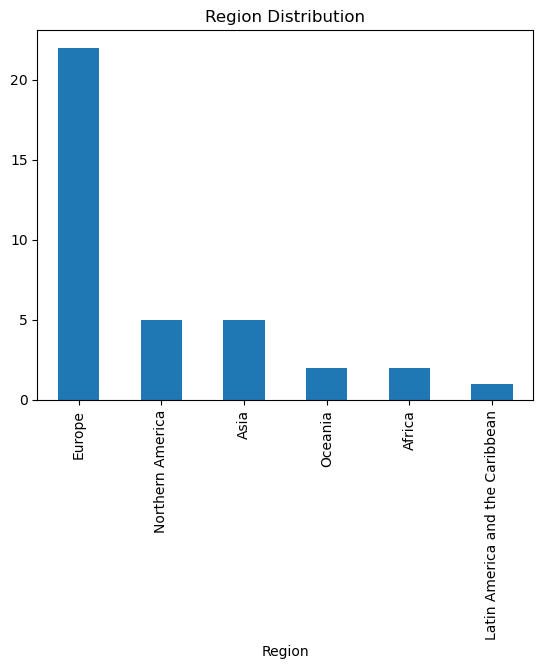

In [21]:
# ---------------------------------------------------------------------
# E. Visual and file checks
# ---------------------------------------------------------------------
# Visual summaries
display(df_final["World Bank Income Group"].value_counts(dropna=False))
display(df_final["Region"].value_counts(dropna=False))

# Save visual summaries
os.makedirs("intermediate_checks/overall_dist", exist_ok=True)
df_final["World Bank Income Group"].value_counts(dropna=False).plot(kind='bar', title="World Bank Income Group Distribution")
df_final["Region"].value_counts(dropna=False).plot(kind='bar', title="Region Distribution")

# Optionally save to Excel
df_final.to_excel("intermediate_checks/final_with_income_region.xlsx", index=False)
print("✅ Saved: intermediate_checks/final_with_income_region.xlsx")

## 🧹Step 7 — Clean, Save & Export

In [22]:
def save_non_anonymized_dataset(df, save_dir="intermediate_checks"):
    """
    Removes identifying columns and saves a non-anonymized cleaned dataset.
    """
    identifying_columns = [
        "IP Address", "Date Created", "Date Modified",
        "Email", "Email address",  # to handle alternate naming
        "First Name", "First name  ",
        "Last Name", "Last name  ",
        "Duration (sec)", "Collector ID",
        "Custom Value", "Response Status"
    ]

    # Keep only columns that actually exist in the dataframe
    existing_columns = [col for col in identifying_columns if col in df.columns]

    if existing_columns:
        df_cleaned = df.drop(columns=existing_columns)
        print(f"🧹 Removed {len(existing_columns)} identifying columns.")
    else:
        df_cleaned = df.copy()
        print("⚠️ No identifying columns found — dataset unchanged.")

    # Ensure directory exists
    os.makedirs(save_dir, exist_ok=True)

    # File paths
    excel_path = os.path.join(save_dir, "PT_cleaned_full_dataset_not_anonymized.xlsx")
    csv_path = os.path.join(save_dir, "PT_cleaned_full_dataset_not_anonymized.csv")

    # Save outputs
    df_cleaned.to_excel(excel_path, index=False)
    df_cleaned.to_csv(csv_path, index=False)

    print(f"✅ Saved cleaned non-anonymized dataset:\n📁 {excel_path}\n📁 {csv_path}")

    return df_cleaned

In [23]:
df_not_anonymized = save_non_anonymized_dataset(df_final)

🧹 Removed 11 identifying columns.
✅ Saved cleaned non-anonymized dataset:
📁 intermediate_checks/PT_cleaned_full_dataset_not_anonymized.xlsx
📁 intermediate_checks/PT_cleaned_full_dataset_not_anonymized.csv


# 🧹Step 7 — Clean & Save Anonymized Dataset

In [24]:
def save_all_clean_outputs(df_final):
    """
    Cleans and exports both anonymized and non-anonymized versions of df_final,
    and exports key disaggregation distributions.
    """

    # -------------------------------
    # STEP 7: Save non-anonymized dataset
    # -------------------------------
    identifying_columns_not_anon = [
        'IP Address', 'Date Created', 'Date Modified', 'Email',
        'First Name', 'Last Name', 'Duration (sec)', 'Collector ID',
        'Custom Value', 'Response Status'
    ]

    df_not_anon = df_final.copy()
    df_not_anon = df_not_anon.drop(
        columns=[col for col in identifying_columns_not_anon if col in df_not_anon.columns],
        errors='ignore'
    )

    df_not_anon.to_excel("PT_cleaned_full_dataset_not_anonymized.xlsx", index=False)
    df_not_anon.to_csv("PT_cleaned_full_dataset_not_anonymized.csv", index=False)
    print("✅ Saved not-anonymized dataset.")

    # -------------------------------
    # STEP 8: Save anonymized dataset
    # -------------------------------
    identifying_columns_anon = [
        'First name', 'Last name', 'Job title', 'Email.1',
        'Company name', 'Collector Type'
    ]

    df_anon = df_not_anon.copy()
    df_anon = df_anon.drop(
        columns=[col for col in identifying_columns_anon if col in df_anon.columns],
        errors='ignore'
    )

    df_anon.to_excel("PT_cleaned_full_dataset_anonymized.xlsx", index=False)
    df_anon.to_csv("PT_cleaned_full_dataset_anonymized.csv", index=False)
    print("✅ Saved anonymized dataset.")

    # -------------------------------
    # STEP 9: Export value counts
    # -------------------------------
    os.makedirs('intermediate_checks/overall_dist', exist_ok=True)
    disagg_map = {
        "World Bank Income Group": "income_group.csv",
        "Region": "region.csv",
        "Country": "country.csv",
        "SBTi Status": "sbti_status.csv",
        "Category A/B": "catA_B.csv"
    }

    exported = 0
    for col, filename in disagg_map.items():
        if col in df_anon.columns:
            df_anon[col].value_counts(dropna=False).to_csv(
                f"intermediate_checks/overall_dist/{filename}"
            )
            print(f"📊 Exported value counts for '{col}'")
            exported += 1
        else:
            print(f"⚠️ Skipped '{col}' — column not found.")

    print(f"\n✨ Export complete: {exported} distribution files saved.")
    print("🎯 All cleaned outputs successfully generated!")

    return df_not_anon, df_anon


In [25]:
df_not_anon, df_anon = save_all_clean_outputs(df_final)

✅ Saved not-anonymized dataset.
✅ Saved anonymized dataset.
📊 Exported value counts for 'World Bank Income Group'
📊 Exported value counts for 'Region'
📊 Exported value counts for 'Country'
📊 Exported value counts for 'SBTi Status'
📊 Exported value counts for 'Category A/B'

✨ Export complete: 5 distribution files saved.
🎯 All cleaned outputs successfully generated!
